# Input data generator
- Generate input to `trigger_test` test bench

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

DATA_DIR = Path('axi_bench/axi_bench.sim/sim_1/behav/xsim/')

## MKID data reader

In [2]:
from mkid_pylibs.readfile import readfile_swp, readfile_tod
swps = readfile_swp('rhea', 'run03/mulswp.rawdata', index='all', lo=5.15e9)
paths = sorted(Path('./run03/').glob('tod_trg_*'))
tods = readfile_tod('rhea', paths[3], lo=5.15e9, index='all')

In [3]:
for swp in swps:
    swp.fitIQ()
    
todrews = [swp.fitresult.rewind(tod.frequency, tod.iq) for swp, tod in zip(swps, tods)]

ADD PARAM -> arga                 : <class 'inspect._empty'>
ADD PARAM -> absa                 : <class 'inspect._empty'>
ADD PARAM -> tau                  : <class 'inspect._empty'>
ADD PARAM -> fr                   : <class 'inspect._empty'>
ADD PARAM -> Qr                   : <class 'inspect._empty'>
ADD PARAM -> Qc                   : <class 'inspect._empty'>
ADD PARAM -> phi0                 : <class 'inspect._empty'>
ADD PARAM -> c                    : <class 'inspect._empty'>
ADD PARAM DEFAULT -> arga                 : -2.412133152017039
ADD PARAM DEFAULT -> absa                 : 0.22475057265288567
ADD PARAM DEFAULT -> tau                  : 6.01938564604693e-07
ADD PARAM DEFAULT -> fr                   : 5131690000.0
ADD PARAM DEFAULT -> Qr                   : 7227.732394366197
ADD PARAM DEFAULT -> Qc                   : 7227.732394366197
ADD PARAM DEFAULT -> phi0                 : 0
ADD PARAM DEFAULT -> c                    : 0
ADD PARAM DEFAULT -> Qi                   : <Pa

C:\Users\kucmb\AppData\Roaming\Python\Python37\site-packages\asteval\astutils.py:233: RuntimeWarning: divide by zero encountered in double_scalars
  ast.Div: lambda a, b: a / b,


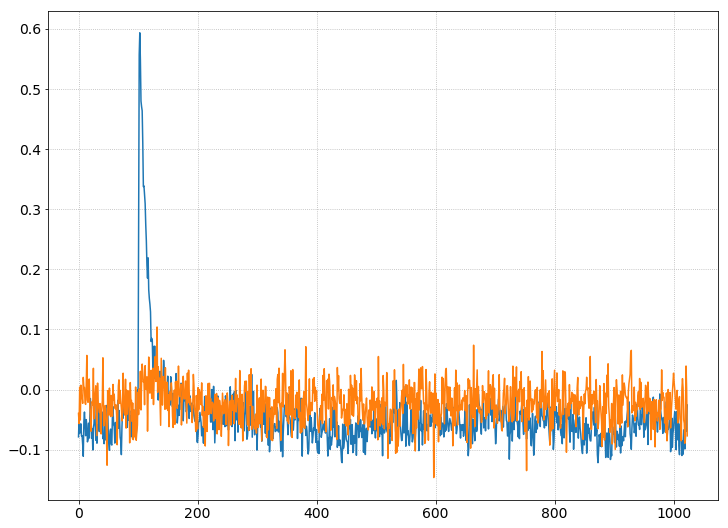

In [4]:
plt.plot(-np.angle(-todrews[0]))
plt.plot(-np.angle(-todrews[1]))

In [5]:
tods[0].frequency

5131650000.0

In [6]:
swps[0].fitresult.params

name,value,standard error,relative error,initial value,min,max,vary,expression
arga,143.833304,6.41868072,(4.46%),-2.412133152017039,-inf,inf,True,
absa,0.24110125,2.5306e-04,(0.10%),0.22475057265288567,-inf,inf,True,
tau,6.0647e-07,1.9907e-10,(0.03%),6.01938564604693e-07,-inf,inf,True,
fr,5.1316e+09,1567.42493,(0.00%),5131690000.0,-inf,inf,True,
Qr,5587.14843,19.0718650,(0.34%),7227.732394366197,-inf,inf,True,
Qc,8582.71357,30.4194731,(0.35%),7227.732394366197,-inf,inf,True,
phi0,0.08193266,0.00371106,(4.53%),0,-inf,inf,True,
c,3.9875e-09,1.2512e-09,(31.38%),0,-inf,inf,True,
Qi,15908.4266,62.7174919,(0.39%),inf,-inf,inf,False,1/(1/Qr - 1/Qc*cos(phi0))


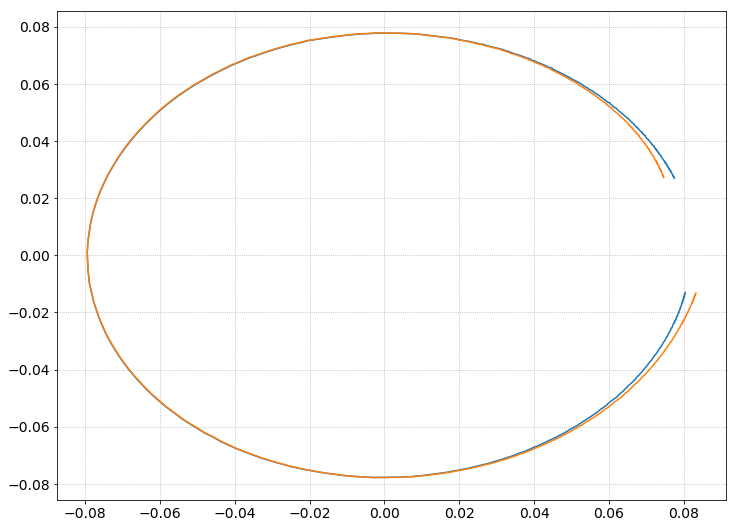

In [7]:
p = swps[0].fitresult.params
data_r = np.exp(1j*(2*np.pi*p['tau']*swps[0].frequency - p['arga']))*swps[0].iq
center = p['absa']*(1 - 0.5*p['Qr']/p['Qc']*np.exp(1j*p['phi0']))
data_f = (data_r - center)*np.exp(-1j*p['phi0'])
plt.plot(data_f.real, data_f.imag)

factor = p['absa']*0.5*p['Qr']/p['Qc']

rewswp = swps[0].fitresult.rewind(swps[0].frequency, swps[0].iq)
plt.plot(factor*rewswp.real*2, factor*rewswp.imag*2)

In [8]:
def rew_simple(freq, param, data):
    p = param
    data_r = np.exp(1j*(2*np.pi*p['tau']*freq - p['arga']))*data
    center = p['absa']*(1 - 0.5*p['Qr']/p['Qc']*np.exp(1j*p['phi0']))
    data_f = (data_r - center)*np.exp(-1j*p['phi0'])
    
    return data_f

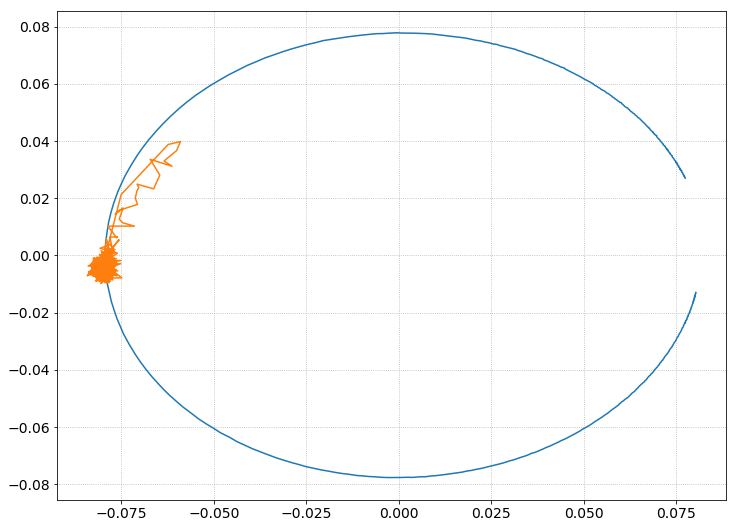

In [9]:
todtmp = rew_simple(tods[0].frequency, p, tods[0].iq)
todtmp2 = rew_simple(tods[1].frequency, swps[1].fitresult.params, tods[1].iq)
plt.plot(data_f.real, data_f.imag)
plt.plot(todtmp.real, todtmp.imag)

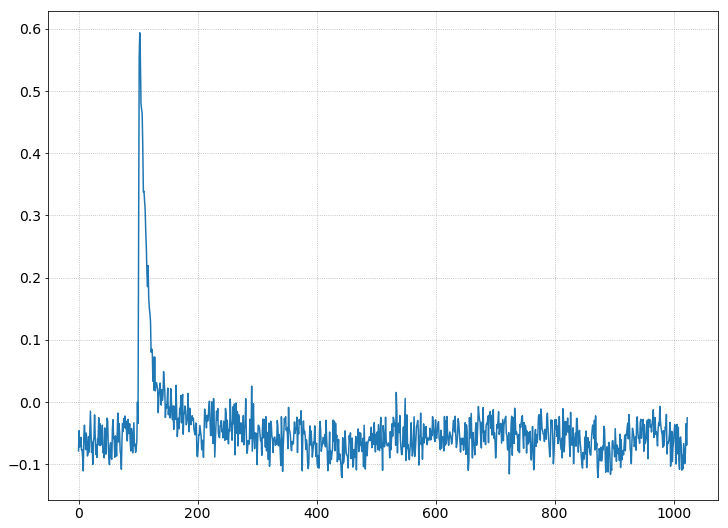

In [10]:
plt.plot(np.angle(-np.conj(todtmp)))

## Parameter input

- Original code

```C++
compd tmp_c (tmp_i.to_double(), tmp_q.to_double());

// Cable rewinding.
double tmp_phase_rew = -phase_rew[i];

compd tmp_rew;
rotation(tmp_c, tmp_rew, tmp_phase_rew);

// Offset shifting
double tmp_off_r = offset_real[i];
double tmp_off_i = offset_imag[i];
compd tmp_off(tmp_rew.real() - tmp_off_r, tmp_rew.imag() - tmp_off_i);

// phi_0 rotation
double tmp_phase_phi = -phi_0[i];
compd tmp_phi_rot;
rotation(tmp_off, tmp_phi_rot, tmp_phase_phi);

// Invert real axis.
// This circumvents -pi/pi chattering, making triggering easier.
compd tmp_fin = -std::conj(tmp_phi_rot);
```

- `phase_rew`: `-2*np.pi*p['tau']*freq + p['arga']`
- `offset_real`: `center.real`
    - `center = p['absa']*(1 - 0.5*p['Qr']/p['Qc']*np.exp(1j*p['phi0']))`
- `offset_imag`: `center.imag`
- `phi_0`: `p['phi0']`

In [38]:
def get_params(param, freq):
    phase_rew = -2*np.pi*param['tau']*freq + param['arga']
    center = param['absa']*(1 - 0.5*param['Qr']/param['Qc']*np.exp(1j*param['phi0']))
    offset_real = center.real*200.* (2**28)
    offset_imag = center.imag*200.* (2**28)
    phi_0 = param['phi0'].value
    
    return phase_rew, offset_real, offset_imag, phi_0

In [39]:
inds = [0, 1] + [0]*14
plist = [get_params(swps[ind].fitresult.params, tods[ind].frequency) for ind in inds]

f_phase = open(DATA_DIR.joinpath('tb_phase_rew.dat'), 'w')
f_off_r = open(DATA_DIR.joinpath('tb_offset_real.dat'), 'w')
f_off_i = open(DATA_DIR.joinpath('tb_offset_imag.dat'), 'w')
f_phi_0 = open(DATA_DIR.joinpath('tb_phi_0.dat'), 'w')

def get_rep(dval):
    raw = np.float64(dval).tobytes()
    rep = ''.join([f'{num:08b}' for num in raw[::-1]])
    rep += '\n'

    return rep

for p_tmp in plist:
    f_phase.write(get_rep(p_tmp[0]))
    f_off_r.write(get_rep(p_tmp[1]))
    f_off_i.write(get_rep(p_tmp[2]))
    f_phi_0.write(get_rep(p_tmp[3]))
    
f_phase.close()
f_off_r.close()
f_off_i.close()
f_phi_0.close()

In [13]:
np.frombuffer(int(get_rep(p_tmp[3]), 2).to_bytes(8, 'little'))

array([0.08193266])

In [14]:
plist[0]

(-19410.76352761298,
 8745027629.961014,
 -344806934.64923906,
 0.08193266162397922)

## Data input

- Lower 48 bit: I
- Higher 48 bit: Q

In [16]:
# Version 2: with valid signal
data_input_i = [[int(d*200.* (2**28)).to_bytes(6, 'little', signed=True) for d in tod.i] for tod in tods]
data_input_q = [[int(d*200.* (2**28)).to_bytes(6, 'little', signed=True) for d in tod.q] for tod in tods]


with open(DATA_DIR.joinpath('tb_data.dat'), 'w') as f_data:
    for index in range(len(data_input_i[0])):
        for channel in range(256):
            rep = ''.join([f'{num:08b}' for num in data_input_q[channel%2][index]][::-1])
            rep += ''.join([f'{num:08b}' for num in data_input_i[channel%2][index]][::-1])
            rep += f' {1 if channel < 16 else 0}'
            f_data.write(rep + '\n')

# Analysis

In [40]:
with open(DATA_DIR.joinpath('tb_dout.dat'), 'r') as f:
    data = f.readlines()
    length = 16*(len(data)//16)
    data_u = np.array([int.from_bytes(int(line[0:48], 2).to_bytes(6, 'little'), 'little', signed=True) for line in data[:length]]).reshape(-1, 16)
    data_l = np.array([int.from_bytes(int(line[48:96], 2).to_bytes(6, 'little'), 'little', signed=True) for line in data[:length]]).reshape(-1, 16)

In [49]:
with open(DATA_DIR.joinpath('tb_pout.dat'), 'r') as f:
    data = f.readlines()
    length = 16*(len(data)//16)
    data_f = np.array([np.frombuffer(int(line, 2).to_bytes(8, 'little'), dtype=np.float64) for line in data[:length]]).reshape(-1, 16)

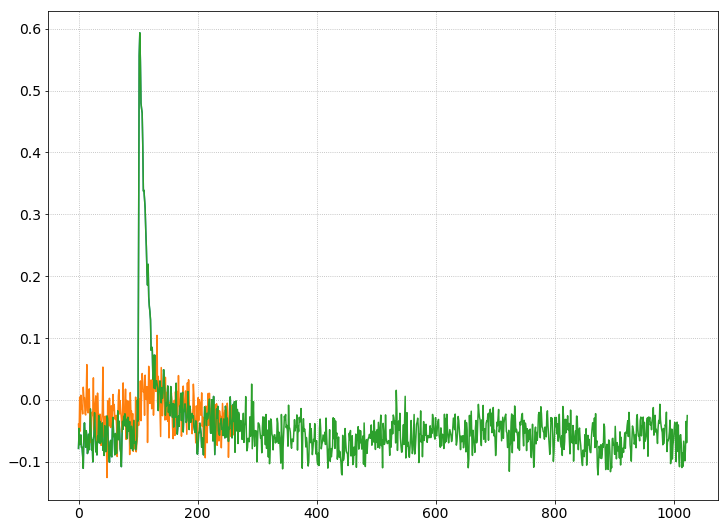

In [51]:
plt.plot(data_f[:,0])
plt.plot(data_f[:,1])
plt.plot(np.angle(-np.conj(todtmp)))
#plt.plot(-np.angle(-np.conj(todtmp)))

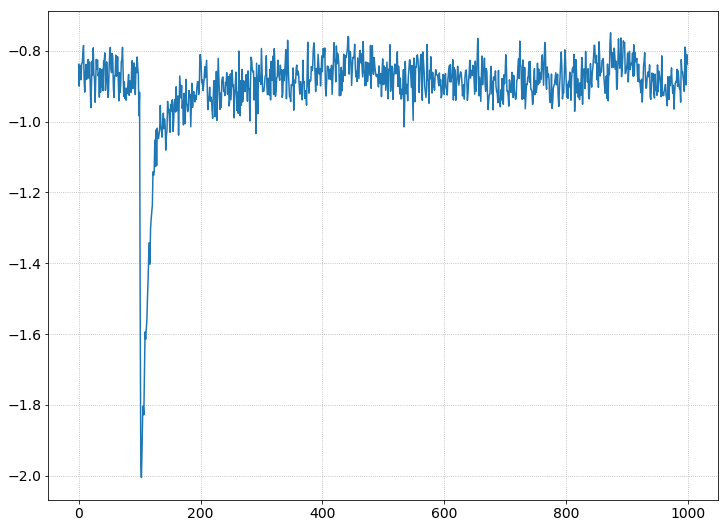

In [22]:
plt.plot(data_f[:,0] - np.angle(-np.conj(todtmp))[:1000])

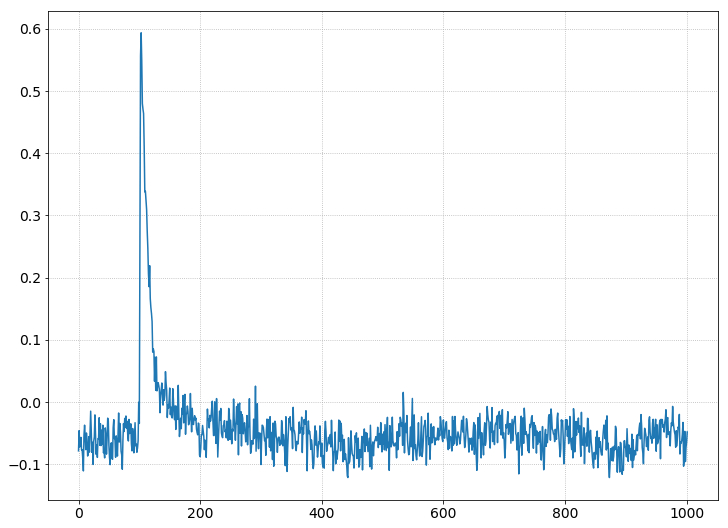

In [23]:
hoge = data_l + 1j*data_u

def rotation(raw, phase):
    s = np.sin(phase)
    c = np.cos(phase)
    
    return (raw.real*c - raw.imag*s) + 1j*(raw.real*s + raw.imag*c)

def rewind(data, params):
    phase_rew, offset_real, offset_imag, phi_0 = params
    
    tmp_rew = rotation(data, -phase_rew)
#    tmp_off = (tmp_rew.real - offset_real*200*(2**28)) + 1j*(tmp_rew.imag - offset_imag*200*(2**28))
    tmp_off = (tmp_rew.real - offset_real) + 1j*(tmp_rew.imag - offset_imag)
    tmp_phi_rot = rotation(tmp_off, -phi_0)
    
    tmp_fin = -np.conj(tmp_phi_rot)
    
    return np.arctan2(tmp_fin.imag, tmp_fin.real)

plt.plot(rewind(hoge[:,0], plist[0]))

In [ ]:
hoge

In [ ]:
[int.from_bytes(d, 'little', signed=True) for d in data_input_i]

In [ ]:
int.from_bytes(data_input_q[0][0], 'little', signed=True)

In [ ]:
hoge[0][0]